# 06: Onshore multi-objective

In this example, we will demonstrate `Ard`'s ability to run a multi-objective analysis and optimization.

We can start by loading what we need to run the problem.

In [1]:
from pathlib import Path  # optional, for nice path specifications

import pprint as pp  # optional, for nice printing
import numpy as np  # numerics library
import matplotlib.pyplot as plt  # plotting capabilities

import ard  # technically we only really need this
from ard.utils.io import load_yaml  # we grab a yaml loader here
from ard.api import set_up_ard_model  # the secret sauce
from ard.viz.layout import plot_layout  # a plotting tool!
from ard.viz.utils import get_plot_range  # buffered range tool

import openmdao.api as om  # for N2 diagrams from the OpenMDAO backend

%matplotlib inline

This will do for now.
We can probably make it a bit cleaner for a later release.

Now, we can set up a case.
We do it a little verbosely so that our documentation system can grab it, you can generally just use relative paths.
We grab the file at `inputs/ard_system.yaml`, which describes the `Ard` system for this problem.
It references, in turn, the `inputs/windio.yaml` file, which is where we define the plant we want to optimize, and an initial setup for it.

In [2]:
# load input
path_inputs = Path.cwd().absolute() / "inputs"
input_dict = load_yaml(path_inputs / "ard_system.yaml")

# create and setup system
prob = set_up_ard_model(input_dict=input_dict, root_data_path=path_inputs)

Running OpenMDAO util to clean the output directories...
	Found 1 OpenMDAO output directories:
	Removed case_files/ard_problem_out
	Removed 1 OpenMDAO output directories.
... done.

Created top-level OpenMDAO problem: top_level.
Adding top_level.
	Adding layout2aep.
		Adding layout to layout2aep.
		Adding aepFLORIS to layout2aep.
	Activating approximate totals on layout2aep
	Adding boundary.
	Adding landuse.
	Adding collection.
	Adding spacing_constraint.
	Adding tcc.
	Adding landbosse.
	Adding opex.
	Adding financese.
System top_level built.
System top_level set up.


Above, you should see each of the groups or components described as they are added to the `Ard` model and, occasionally, some options being turned on on them, like semi-total finite differencing on groups.

Next is some code you can flip on to use the [N2 diagram vizualization tools from the backend toolset, OpenMDAO, that we use](https://openmdao.org/newdocs/versions/latest/features/model_visualization/n2_basics/n2_basics.html).
This can be a really handy debugging tool, if somewhat tricky to use; turned on it will show a comprehensive view of the system in terms of its components, variables, and connections, although we leave it off for now.

In [3]:
if False:
    # visualize model
    om.n2(prob)

Now, we do a one-shot analysis.
The one-shot analysis will run a wind farm as specified in `inputs/windio.yaml` and with the models specified in `inputs/ard_system.yaml`, then dump the outputs.

In [4]:
# run the model
prob.run_model()

# collapse the test result data
test_data = {
    "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
    "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
    "BOS_val": float(prob.get_val("landbosse.total_capex", units="MUSD")[0]),
    "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
    "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
    "area_tight": float(prob.get_val("landuse.area_tight", units="km**2")[0]),
    "coll_length": float(prob.get_val("collection.total_length_cables", units="km")[0]),
    "turbine_spacing": float(
        np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
    ),
}

print("\n\nRESULTS:\n")
pp.pprint(test_data)
print("\n\n")



RESULTS:

{'AEP_val': 406.5372933434125,
 'BOS_val': 41.68227106807093,
 'CapEx_val': 110.5,
 'LCOE_val': 37.274982094458494,
 'OpEx_val': 3.7400000000000007,
 'area_tight': 13.2496,
 'coll_length': 21.89865877023397,
 'turbine_spacing': 0.91}





Now, we can optimize the same problem to understand the tradeoff between LCOE and land use area!
The optimization details are set under the `analysis_options` header in `inputs/ard_system.yaml`.
Here, we still use the four-dimensional rectilinear layout parameterization ($\theta$) as design variables, constrain the farm such that the turbines are in the boundaries and satisfactorily spaced, and then we optimize for both LCOE and land use area.
$$
\begin{aligned}
\textrm{minimize}_\theta \quad & \begin{pmatrix}
    A_{\mathrm{landuse}}(\theta, \ldots) \\
    \mathrm{LCOE}(\theta, \ldots)
\end{pmatrix} \\
\textrm{subject to} \quad & f_{\mathrm{spacing}}(\theta, \ldots) < 0 \\
                          & f_{\mathrm{boundary}}(\theta, \ldots) < 0
\end{aligned}
$$

In [5]:
optimize = True  # set to False to skip optimization
if optimize:
    # run the optimization
    prob.run_driver()

    # collapse the test result data
    test_data = {
        "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
        "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
        "BOS_val": float(prob.get_val("landbosse.total_capex", units="MUSD")[0]),
        "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
        "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
        "area_tight": float(prob.get_val("landuse.area_tight", units="km**2")[0]),
        "coll_length": float(
            prob.get_val("collection.total_length_cables", units="km")[0]
        ),
        "turbine_spacing": float(
            np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
        ),
    }

    # clean up the recorder
    prob.cleanup()

    # print the results
    print("\n\nRESULTS (opt):\n")
    pp.pprint(test_data)
    print("\n\n")

generation: 0 of 10
generation: 1 of 10
generation: 2 of 10
generation: 3 of 10
generation: 4 of 10
generation: 5 of 10
generation: 6 of 10
generation: 7 of 10
generation: 8 of 10
generation: 9 of 10
generation: 10 of 10


RESULTS (opt):

{'AEP_val': 424.40487848403035,
 'BOS_val': 39.600972465841274,
 'CapEx_val': 110.5,
 'LCOE_val': 35.337890055621564,
 'OpEx_val': 3.7400000000000007,
 'area_tight': 4.701829411011188,
 'coll_length': 11.907005558904213,
 'turbine_spacing': 0.43220837800684214}





The result is no longer a single farm... we need to extract the multi-objective data now.

In [6]:
# Extract the multi-objective data from the driver
obj_nd = prob.driver.obj_nd.copy()
obj_nd = obj_nd[obj_nd[:, 0].argsort()]  # Sort rows by the first column

In [7]:
# Access the recorder data
case_reader = om.CaseReader(prob.get_outputs_dir() / "cases.sql")

# Get all driver cases
driver_cases = case_reader.list_cases("driver", out_stream=None)

# Extract data from all cases
results = []
for case_id in driver_cases:

    case = case_reader.get_case(case_id)

    # Extract specific variables you're interested in
    result = {
        "case_id": case_id,
        "LCOE": case.get_val("financese.lcoe", units="USD/MW/h")[0],
        "area_tight": case.get_val("area_tight", units="km*km")[0],
    }
    results.append(result)

# Convert to arrays for plotting/analysis
case_id_history = np.array([int(r["case_id"].split("|")[-1]) for r in results])
lcoe_history = np.array([r["LCOE"] for r in results])
area_tight_history = np.array([r["area_tight"] for r in results])

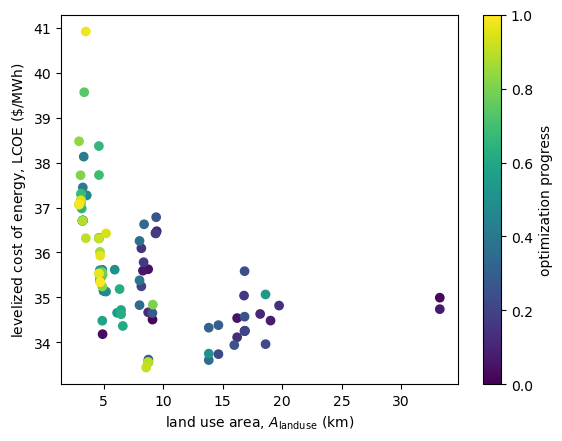

In [8]:
# Plot all of the points in the optimization histories
fig, ax = plt.subplots()
ct0 = ax.scatter(area_tight_history, lcoe_history, c=case_id_history / max(case_id_history))
cb0 = fig.colorbar(ct0)
ax.set_xlabel("land use area, $A_{\\mathrm{landuse}}$ (km)")
ax.set_ylabel("levelized cost of energy, $\\mathrm{LCOE}$ (\\$/MWh)")
cb0.set_label("optimization progress")

These results can be hit or miss when there are not enough points sampled.
We use a population size of ten per generation over ten generations for the example, which is _not_ a lot.
But we should see that as the optimization progresses, the points should tend toward lower LCOE and lower land use.
You can change `pop_size` and `max_gen` in `inputs/ard_system:analysis_options` to improve the resolution of the Pareto fronts.

We can also post-process the results to extract the Pareto front.

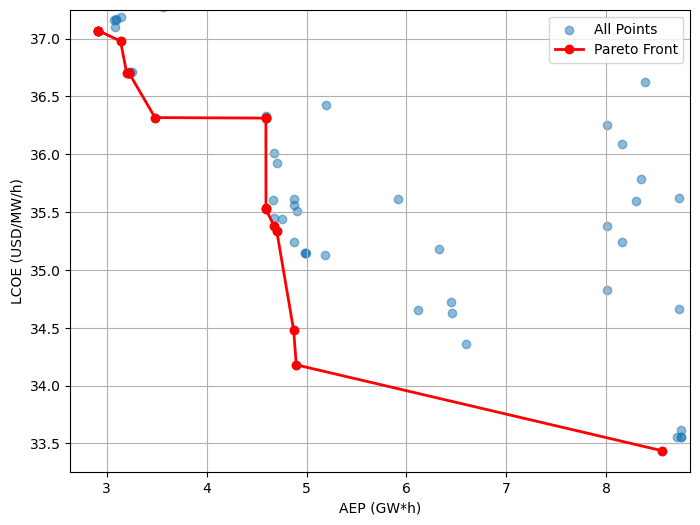

In [9]:
# Combine AEP and LCOE into a single array for easier processing
data = np.column_stack((area_tight_history, lcoe_history))

# Sort by AEP (descending) and then by LCOE (ascending)
data = data[np.lexsort((lcoe_history, area_tight_history))]

# Compute the Pareto front
pareto_front = [data[0]]
for point in data[1:]:
    if point[1] < pareto_front[-1][1]:  # Check if LCOE is lower
        pareto_front.append(point)

pareto_front = np.array(pareto_front)

# Extract AEP and LCOE values for the Pareto front
pareto0 = pareto_front[:, 0]
pareto1 = pareto_front[:, 1]

# Plot the Pareto front
plt.figure(figsize=(8, 6))
plt.scatter(area_tight_history, lcoe_history, label="All Points", alpha=0.5)
plt.plot(pareto0, pareto1, "-o", color="red", label="Pareto Front", linewidth=2)
plt.xlabel("AEP (GW*h)")
plt.ylabel("LCOE (USD/MW/h)")
plt.legend()
plt.grid(True)
plt.xlim(*get_plot_range(pareto0))
plt.ylim(*get_plot_range(pareto1))
plt.show()